In [1]:
# importing useful modules and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import norm
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# “Southern oscillation index" data

## Reading the data

In [2]:
# Read from data file
df_soi = pd.read_csv('soi.tsv', sep='\t', header=None).transpose()
df_soi.columns = ['Southern Oscillation Index']

# Dropping nan values
df_soi = df_soi.dropna()

# First 5 observations
df_soi.head()

,Southern Oscillation Index
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


## Plot the data

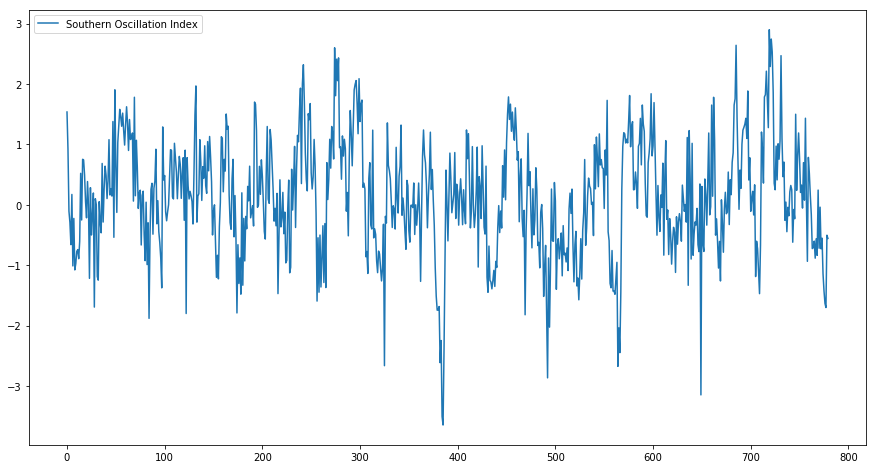

In [3]:
# Plot the data
df_soi.plot(figsize=(15,8))
plt.show()

## Autocorrelation and partial autocorrelation functions

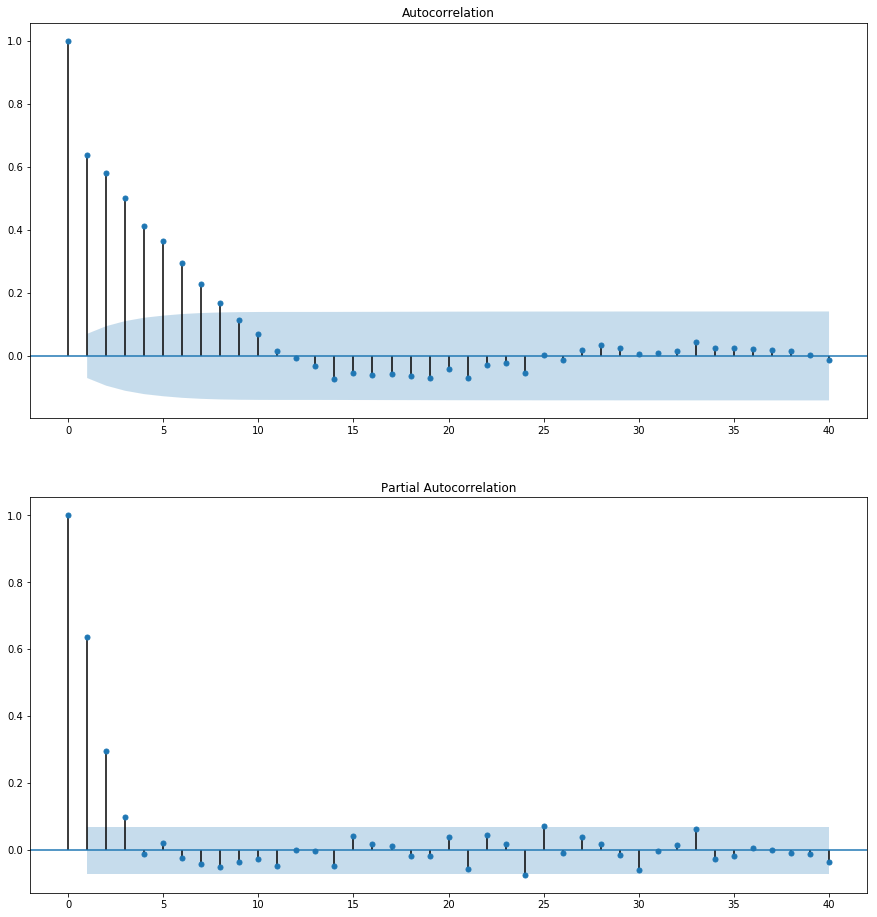

In [4]:
plt.figure(figsize=(15,16))

# Plot autocorrelation
ax = plt.subplot(211)
plot_acf(df_soi.values, lags=40, ax=ax)

# Plot partial autocorrelation
ax = plt.subplot(212)
plot_pacf(df_soi.values, lags=40, ax=ax)
plt.show()

**Observations**: We can use these plots to determine a p order for an AR(p) model. We can choose p for the lag value where the PACF chart crosses the upper confidence interval for the first time. Therefore, here we can choose **p=4**.

## AR model train
  
We will perform a AR(4) model according to the acf and pcaf functions plots.

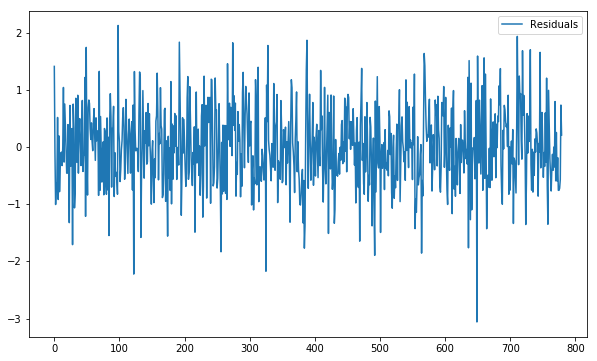

        Residuals
count  780.000000
mean    -0.002198
std      0.694478
min     -3.058077
25%     -0.479530
50%     -0.007303
75%      0.442304
max      2.123565


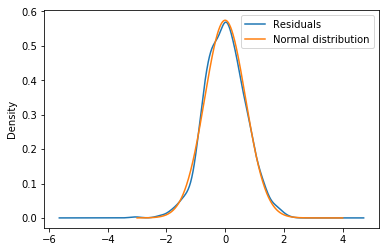

In [5]:
# Fitting AR model with p=4
model = ARIMA(df_soi.values, order=(4,0,0))
model_fit = model.fit()

# Getting residuals
residuals = pd.DataFrame(model_fit.resid, columns=['Residuals'])

# Plot residual errors
residuals.plot(figsize=(10,6))
plt.show()

# Residuals description
print(residuals.describe())

# residual distribution
ax = residuals.plot(kind='kde', label='Residuals estimate distribution')

# normal distribution
x = np.linspace(-3,4,500)
y = norm.pdf(x, loc=residuals.mean(), scale=residuals.std())
ax.plot(x,y, label='Normal distribution')
plt.legend()
plt.show()

**Observations**: Variance is pretty much centered for the residual errors, and nearly constant over time without see some trend. Residuals fit a nearly perfectly a gaussian distribution for this AR model! It seems to be white noise and the AR model is pretty good.

## Model spectral density

We will evaluate the spectral density of our AR model on the interval [0, 1/2] for the frequency.

In [6]:
# function to evaluate spectral density according to the AR model Phi coefficients
def computeSpectralDensity(w, p, phi, sigma):
    s = 0
    for k in np.arange(1, p+1):
        s += phi[k-1]*np.exp(-2j*np.pi*k*w)
    return (sigma**2)*np.abs(1 - s)**(-2)

In [7]:
# Getting phi coefficient from the model
phi = model_fit.params[1:]

# Evaluating spectral density on [0, 1/2]
spectral_density = []
for f in np.arange(0, 0.5, 0.001):
    w = 2*np.pi*f
    spectral_density.append(computeSpectralDensity(w, 4, phi, residuals.std()))

## Periodogram and spectral density plot

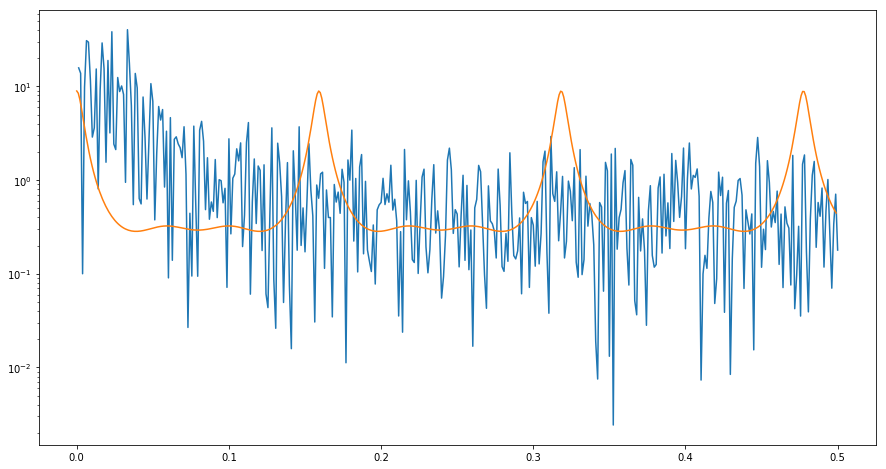

In [8]:
f, Pxx_den = signal.periodogram(df_soi.values, axis=0)

plt.figure(figsize=(15,8))
plt.semilogy(f[1:], Pxx_den[1:])
plt.plot(np.arange(0, 0.5, 0.001), spectral_density)
plt.show()